# Evaluating our Prediction Models with Loss Functions
The Titanic data frames describe the survival status of individual passengers on the Titanic. 

Source the data from the Kaggle repository here: https://www.kaggle.com/c/titanic/data

Execute the tasks listed below:

* Build 2 prediction models of your choice to compute the survival rates of passengers
* Evaluate the quality of your predictions models using the relevant loss functions (use at least 2 loss functions)
* Explain your thoughts on the obtained these results

### Étape 1 : Chargement du dataset Titanic

In [1]:
import pandas as pd

# Charger les données Titanic
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

# Afficher les 5 premières lignes
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Étape 2 : Prétraitement des données
Voici les principales actions à effectuer :

**1. Sélection des colonnes utiles**
Nous allons conserver uniquement les colonnes pertinentes pour la prédiction de la survie (Survived).

Par exemple : Pclass, Sex, Age, Fare, Embarked.

In [2]:
df = df[["Survived", "Pclass", "Sex", "Age", "Fare", "Embarked"]]


**2. Gérer les valeurs manquantes**

In [3]:
# Afficher les valeurs manquantes
print(df.isnull().sum())
print("---------------------------")

# Remplacer les âges manquants par la moyenne
df["Age"].fillna(df["Age"].mean(), inplace=True)

# Remplacer les embarquements manquants par la valeur la plus fréquente
df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)
print(df.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age         177
Fare          0
Embarked      2
dtype: int64
---------------------------
Survived    0
Pclass      0
Sex         0
Age         0
Fare        0
Embarked    0
dtype: int64


**3. Encodage des variables catégorielles (Sex, Embarked)**
On transforme les textes en valeurs numériques :

In [4]:
# Encodage de "Sex" (male = 0, female = 1)
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

# Encodage one-hot de "Embarked"
df = pd.get_dummies(df, columns=["Embarked"], drop_first=True)

In [5]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked_Q,Embarked_S
0,0,3,0,22.0,7.2500,False,True
1,1,1,1,38.0,71.2833,False,False
2,1,3,1,26.0,7.9250,False,True
3,1,1,1,35.0,53.1000,False,True
4,0,3,0,35.0,8.0500,False,True


### Étape 3 : Création de deux modèles de classification
Nous allons créer deux modèles pour prédire la colonne Survived :

* Régression Logistique
* Forêt Aléatoire (Random Forest)

**1. Séparation des variables indépendantes et dépendantes**

In [6]:
from sklearn.model_selection import train_test_split

# Variables explicatives (X) et variable cible (y)
X = df.drop("Survived", axis=1)
y = df["Survived"]

# Séparer les données en entraînement et test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**2. Entraînement du modèle de régression logistique**

In [7]:
from sklearn.linear_model import LogisticRegression

# Initialiser et entraîner le modèle
model_log = LogisticRegression(max_iter=200)
model_log.fit(X_train, y_train)


LogisticRegression(max_iter=200)

**3. Entraînement du modèle de forêt aléatoire**

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Initialiser et entraîner le modèle
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

### Étape 4 : Évaluation avec les fonctions de perte
Nous allons utiliser deux fonctions de perte adaptées à la classification binaire :

* Log Loss (ou entropie croisée) : adaptée pour les probabilités.
* Hinge Loss : souvent utilisée pour les SVM, nécessite des étiquettes en -1 et 1.


In [9]:
# 1. Log Loss (Entropie croisée)
from sklearn.metrics import log_loss

# Prédictions de probabilité
probas_log = model_log.predict_proba(X_test)
probas_rf = model_rf.predict_proba(X_test)

# Calcul du log loss
logloss_log = log_loss(y_test, probas_log)
logloss_rf = log_loss(y_test, probas_rf)

print(f"Log Loss - Régression Logistique : {logloss_log:.4f}")
print(f"Log Loss - Forêt Aléatoire       : {logloss_rf:.4f}")


Log Loss - Régression Logistique : 0.4213
Log Loss - Forêt Aléatoire       : 0.7666


In [10]:
# 2. Hinge Loss
from sklearn.metrics import hinge_loss

# Conversion de y_test en -1 / 1
y_test_hinge = y_test.replace({0: -1, 1: 1})

# Prédictions (scores) des modèles
preds_log = model_log.predict(X_test)
preds_rf = model_rf.predict(X_test)

# Conversion des prédictions en -1 / 1
preds_log_hinge = pd.Series(preds_log).replace({0: -1, 1: 1})
preds_rf_hinge = pd.Series(preds_rf).replace({0: -1, 1: 1})

# Calcul du hinge loss
hinge_loss_log = hinge_loss(y_test_hinge, preds_log_hinge)
hinge_loss_rf = hinge_loss(y_test_hinge, preds_rf_hinge)

print(f"Hinge Loss - Régression Logistique : {hinge_loss_log:.4f}")
print(f"Hinge Loss - Forêt Aléatoire       : {hinge_loss_rf:.4f}")


Hinge Loss - Régression Logistique : 0.4022
Hinge Loss - Forêt Aléatoire       : 0.4134


### Scoring
Nous allons utiliser les métriques suivantes :

* Accuracy : taux de bonnes prédictions
* Precision, Recall, F1-score
* Courbe ROC + AUC (Area Under the Curve)



In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Prédictions binaires
y_pred_log = model_log.predict(X_test)
y_pred_rf = model_rf.predict(X_test)

# Scores - Régression Logistique
print("=== Régression Logistique ===")
print("Accuracy :", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log))
print("Recall   :", recall_score(y_test, y_pred_log))
print("F1 Score :", f1_score(y_test, y_pred_log))
print()

# Scores - Forêt Aléatoire
print("=== Forêt Aléatoire ===")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1 Score :", f1_score(y_test, y_pred_rf))


=== Régression Logistique ===
Accuracy : 0.7988826815642458
Precision: 0.7638888888888888
Recall   : 0.7432432432432432
F1 Score : 0.7534246575342465

=== Forêt Aléatoire ===
Accuracy : 0.7932960893854749
Precision: 0.7534246575342466
Recall   : 0.7432432432432432
F1 Score : 0.7482993197278911


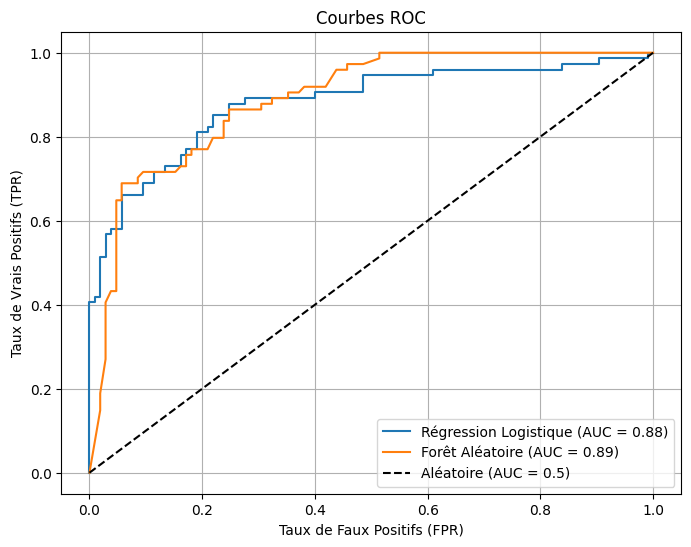

In [12]:
# Probabilités pour la classe positive (Survived = 1)
y_proba_log = model_log.predict_proba(X_test)[:, 1]
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]

# Courbes ROC
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

auc_log = roc_auc_score(y_test, y_proba_log)
auc_rf = roc_auc_score(y_test, y_proba_rf)

# Tracé ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Régression Logistique (AUC = {auc_log:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Forêt Aléatoire (AUC = {auc_rf:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Aléatoire (AUC = 0.5)")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbes ROC")
plt.legend()
plt.grid(True)
plt.show()


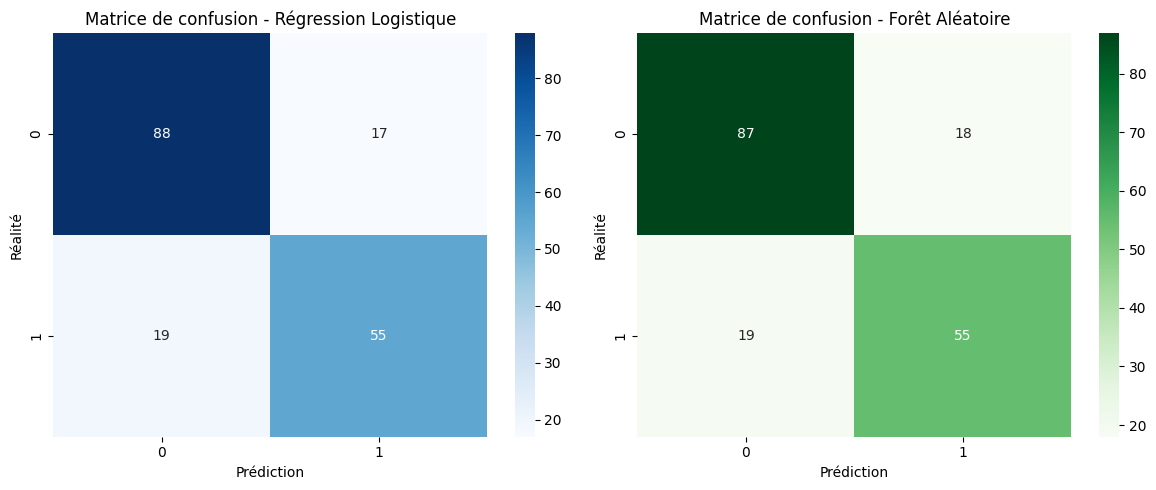

In [15]:
# Matrice de confusion - Logistique
conf_log = confusion_matrix(y_test, y_pred_log)
conf_rf = confusion_matrix(y_test, y_pred_rf)

# Affichage
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(conf_log, annot=True, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_title("Matrice de confusion - Régression Logistique")
axs[0].set_xlabel("Prédiction")
axs[0].set_ylabel("Réalité")

sns.heatmap(conf_rf, annot=True, fmt="d", cmap="Greens", ax=axs[1])
axs[1].set_title("Matrice de confusion - Forêt Aléatoire")
axs[1].set_xlabel("Prédiction")
axs[1].set_ylabel("Réalité")

plt.tight_layout()
plt.show()
